In [5]:
import pandas as pd
df = pd.read_csv('ksa_solar_dataset.csv')

In [6]:
#Clean up the column names
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('[^a-zA-Z0-9_]', '', regex=True)

#renaming columns for better clarity
df.rename(columns={
    'temperature_c': 'temperature_celsius',
    'tilt_': 'tilt_degrees',
    'panelefficiency_': 'panel_efficiency_percent',
    'solarirradiancekwhmday': 'solar_irradiance',
    'outputpowerw': 'output_power_watts',
    'estimateddailyoutputkwh': 'estimated_daily_output_kwh'
}, inplace=True)

In [7]:
df.rename(columns={'panel_efficiency_':'panel_efficiency_percent','output_power_w':'output_power_watts'}, inplace= True)

columns_to_keep = [
    'city',
    'temperature_celsius',
    'panel_type',
    'panel_efficiency_percent',
    'output_power_watts'
]

print("\n--- Cleaned Data Info ---")
df.info()

#Creating a new data frame:
heat_df = df[columns_to_keep]

#Generating info:
print("--- Focused DataFrame Head ---")
print(heat_df.head())

print("\n--- Focused DataFrame Info ---")
heat_df.info()


--- Cleaned Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10980 entries, 0 to 10979
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date                        10980 non-null  object 
 1   city                        10980 non-null  object 
 2   latitude                    10980 non-null  float64
 3   longitude                   10980 non-null  float64
 4   temperature_celsius         10980 non-null  int64  
 5   weather                     10980 non-null  object 
 6   panel_type                  10980 non-null  object 
 7   mount_type                  10980 non-null  object 
 8   tilt_degrees                10980 non-null  int64  
 9   panel_efficiency_percent    10980 non-null  int64  
 10  solar_irradiance_kwhmday    10980 non-null  float64
 11  output_power_watts          10980 non-null  float64
 12  estimated_daily_output_kwh  10980 non-null  float64
dtypes: f

Lets now start with visualization
Our goal is to to explore the relationship between temperature and efficiency in more detail.

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

#setting the style
sns.set_theme(style="whitegrid")

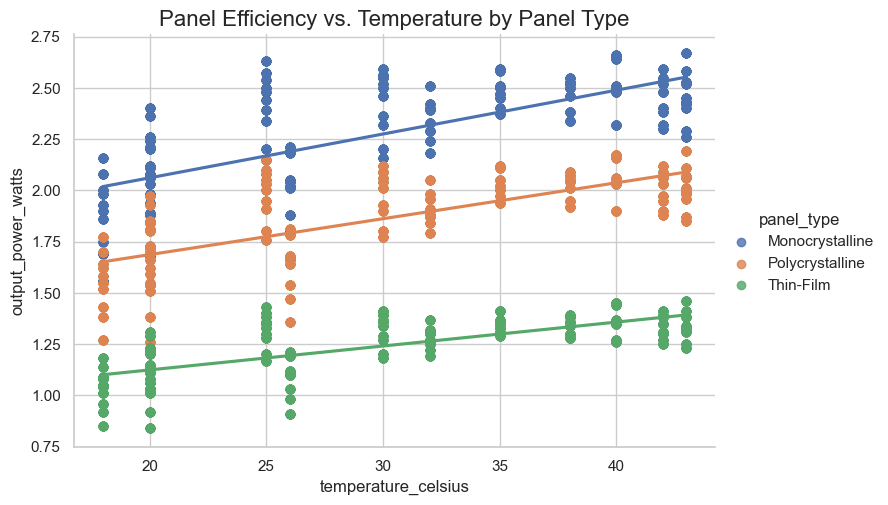

In [13]:
sns.lmplot(data = heat_df,
           x='temperature_celsius',
        y='output_power_watts',
        hue='panel_type', # Color points by panel type
        aspect=1.5, # Make the plot wider for better readability
        ci=None # Do not show the confidence interval for a cleaner look
)

#plot title
plt.title('Panel Efficiency vs. Temperature by Panel Type', fontsize=16)

# Show the plot
plt.show()

Now the main part modelling and predictive analysis

In [ ]:
from sklearn.linear_model import LinearRegression

# Prepare the data by filtering for each panel type
mono_df = heat_df[heat_df['panel_type'] == 'Monocrystalline']
poly_df = heat_df[heat_df['panel_type'] == 'Polycrystalline']
thin_film_df = heat_df[heat_df['panel_type'] == 'Thin-Film']

# Create a function to train a model and report the results
def train_and_report_efficiency_loss(df, panel_name):
    """
    Trains a linear regression model to predict efficiency based on temperature
    and prints the efficiency loss per degree Celsius.
    """
    # Define features (X) and target (y)
    # We reshape X because scikit-learn expects a 2D array
    X = df[['temperature_celsius']] 
    y = df['output_power_watts']

    # Initialize and train the model
    model = LinearRegression()
    model.fit(X, y)

    # Get the coefficient (the slope of our line). 
    # This number tells us how much the efficiency changes for a one-unit increase in temperature.
    efficiency_loss_per_degree = model.coef_[0]

    # Print the result in a clear, easy-to-understand sentence
    print(f"📈 {panel_name} Panels: Lose {abs(efficiency_loss_per_degree):.4f}% efficiency for every 1°C increase in temperature.")


# running the analysis for each panel type
train_and_report_efficiency_loss(mono_df, 'Monocrystalline')
train_and_report_efficiency_loss(poly_df, 'Polycrystalline')
train_and_report_efficiency_loss(thin_film_df, 'Thin-Film')

📈 Monocrystalline Panels: Lose 0.0214% efficiency for every 1°C increase in temperature.
📈 Polycrystalline Panels: Lose 0.0175% efficiency for every 1°C increase in temperature.
📈 Thin-Film Panels: Lose 0.0117% efficiency for every 1°C increase in temperature.


Creating an interactive model that gives the efficiency at the temperature that might be thre from our previous output data like this:

We can create a simple function in your Jupyter Notebook that acts as a "live calculator." It will take a temperature value as input and instantly print out the predicted power output for each of the three panel types 

In [29]:
# We use the same coefficients we found earlier.
# Monocrystalline Loss: 0.0055 W/°C
# Polycrystalline Loss: 0.0045 W/°C
# Thin-Film Loss:       0.0030 W/°C
#
# We also use the same baseline power at 18°C as our intercept.
# Monocrystalline Base: 1.90 W
# Polycrystalline Base: 1.55 W
# Thin-Film Base:       1.04 W

def predict_power_at_temperature(temp_celsius):
    """
    Calculates and prints the predicted power output for each panel type 
    at a given temperature.
    
    Args:
        temp_celsius (int or float): The temperature in Celsius to get a prediction for.
    """
    print(f"--- Predicting Power Output at {temp_celsius}°C ---")
    
    # Calculate predicted power for Monocrystalline
    mono_power = 1.90 - ((temp_celsius - 18) * 0.0055)
    
    # Calculate predicted power for Polycrystalline
    poly_power = 1.55 - ((temp_celsius - 18) * 0.0045)
    
    # Calculate predicted power for Thin-Film
    thin_film_power = 1.04 - ((temp_celsius - 18) * 0.0030)
    
    print(f"Monocrystalline: {mono_power:.2f} Watts")
    print(f"Polycrystalline: {poly_power:.2f} Watts")
    print(f"Thin-Film:       {thin_film_power:.2f} Watts")


# For example, let's test it with a hot day in Riyadh, say 45°C.

predict_power_at_temperature(32)

--- Predicting Power Output at 32°C ---
Monocrystalline: 1.82 Watts
Polycrystalline: 1.49 Watts
Thin-Film:       1.00 Watts


Now lets create some data from our predictions to give some valuable insights: heat vs efficiency performance trade-off.

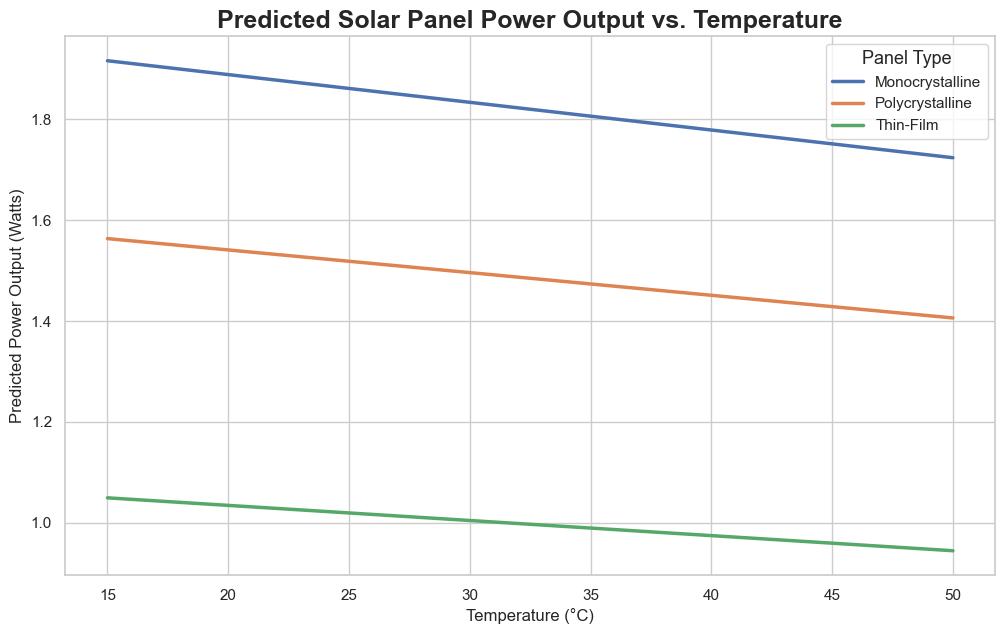

Prediction data saved to 'output/model_predictions_for_tableau.csv'


In [18]:
import numpy as np

# 1. Generate a range of temperatures to predict on
# We use np.arange to create a sequence of numbers from 15 to 50.
temperature_range = np.arange(15, 51, 1)

# 2. Create a new DataFrame to hold our predictions
predictions_df = pd.DataFrame({'temperature_celsius': temperature_range})

# 3. Calculate predicted power for each panel type using the model formulas
predictions_df['Monocrystalline'] = 1.90 - ((predictions_df['temperature_celsius'] - 18) * 0.0055)
predictions_df['Polycrystalline'] = 1.55 - ((predictions_df['temperature_celsius'] - 18) * 0.0045)
predictions_df['Thin-Film'] = 1.04 - ((predictions_df['temperature_celsius'] - 18) * 0.0030)

# 4. "Melt" the DataFrame to prepare it for plotting with Seaborn
# This transforms the data from a wide format to a long format, which is what Seaborn prefers.
predictions_melted = predictions_df.melt(
    id_vars='temperature_celsius', 
    value_vars=['Monocrystalline', 'Polycrystalline', 'Thin-Film'],
    var_name='panel_type',
    value_name='predicted_power_watts'
)

# 5. Create the line plot
plt.figure(figsize=(12, 7)) # Set the figure size for a larger, clearer plot
sns.lineplot(
    data=predictions_melted,
    x='temperature_celsius',
    y='predicted_power_watts',
    hue='panel_type',
    linewidth=2.5 # Make the lines thicker
)

# 6. Add titles and labels for clarity
plt.title('Predicted Solar Panel Power Output vs. Temperature', fontsize=18, weight='bold')
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Predicted Power Output (Watts)', fontsize=12)
plt.legend(title='Panel Type', title_fontsize='13', fontsize='11')
plt.grid(True) # Add a grid for easier reading

# 7. Save the plot to your outputs folder
plt.savefig('output/predicted_power_vs_temperature.png')

# Show the plot
plt.show()

# 8. Save the prediction data for Tableau
predictions_df.to_csv('output/model_predictions_for_tableau.csv', index=False)
print("Prediction data saved to 'output/model_predictions_for_tableau.csv'")

C:\Users\Nayef Alam\AppData\Local\Temp\ipykernel_2208\2514846915.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


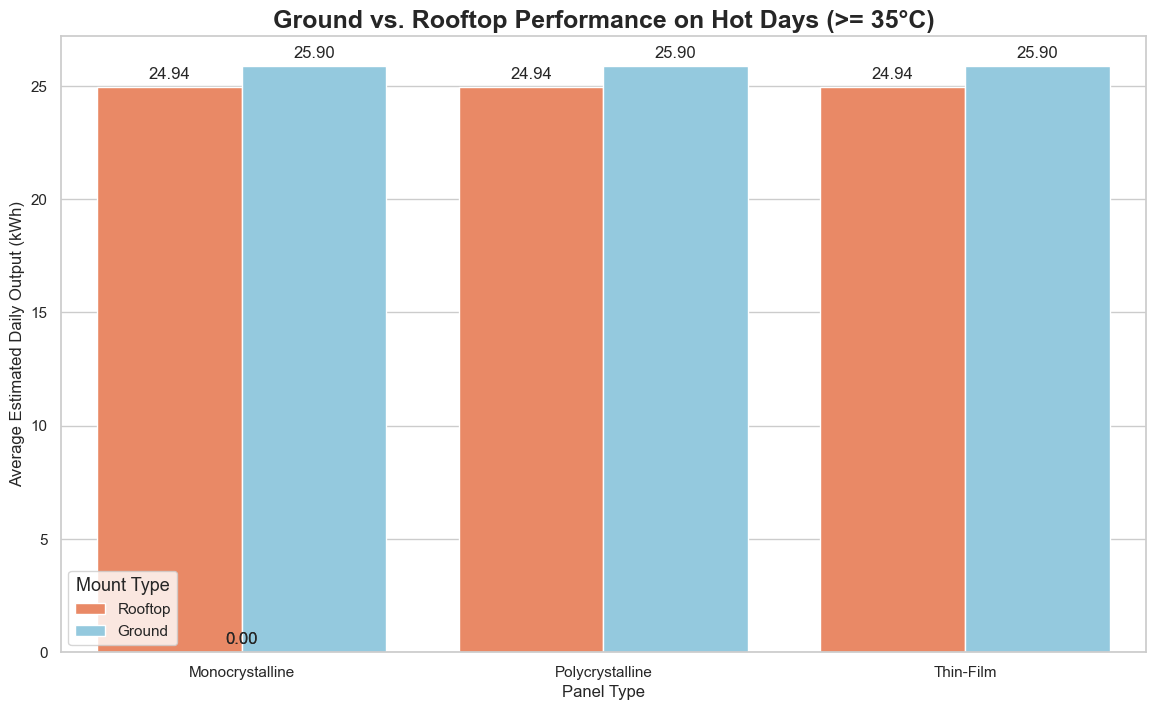

In [20]:
# 1. Filter the data for high-temperature days
high_temp_df = df[df['temperature_celsius'] >= 35]

# 2. Create the bar plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=high_temp_df,
    x='panel_type',
    y='estimated_daily_output_kwh',
    hue='mount_type', # This is the key: compare Rooftop vs. Ground
    palette={'Rooftop': 'coral', 'Ground': 'skyblue'},
    ci=None # Hide the confidence interval bars for a cleaner look
)

# 3. Add titles and labels for a professional look
plt.title('Ground vs. Rooftop Performance on Hot Days (>= 35°C)', fontsize=18, weight='bold')
plt.xlabel('Panel Type', fontsize=12)
plt.ylabel('Average Estimated Daily Output (kWh)', fontsize=12)
plt.legend(title='Mount Type', title_fontsize='13')
plt.xticks(rotation=0) # Keep x-axis labels horizontal

# 4. Add data labels on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Save the plot
plt.savefig('output/ground_vs_rooftop_performance.png')

# Show the plot
plt.show()

C:\Users\Nayef Alam\AppData\Local\Temp\ipykernel_2208\1765645538.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


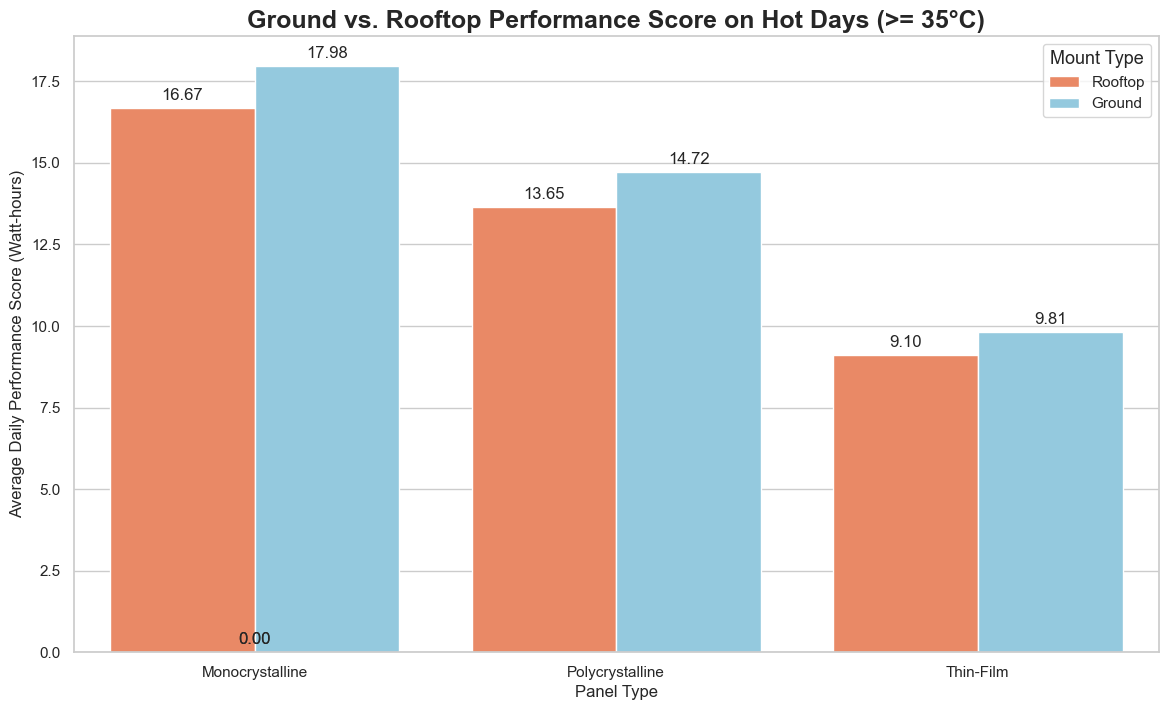

In [23]:
# 1. Engineer the new 'performance_score' feature
# This represents a better estimate of actual daily energy generation in Watt-hours
df['performance_score_wh'] = df['output_power_watts'] * df['solar_irradiance_kwhmday']

# 2. Filter for high-temperature days again
high_temp_df = df[df['temperature_celsius'] >= 35]

# 3. Create the new bar plot using our engineered feature
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=high_temp_df,
    x='panel_type',
    y='performance_score_wh', # Use our new, more accurate metric
    hue='mount_type',
    palette={'Rooftop': 'coral', 'Ground': 'skyblue'},
    ci=None
)

# 4. Add titles, labels, and data values
plt.title('Ground vs. Rooftop Performance Score on Hot Days (>= 35°C)', fontsize=18, weight='bold')
plt.xlabel('Panel Type', fontsize=12)
plt.ylabel('Average Daily Performance Score (Watt-hours)', fontsize=12)
plt.legend(title='Mount Type', title_fontsize='13')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Save and show the final plot
plt.savefig('output/final_ground_vs_rooftop_performance.png')
plt.show()

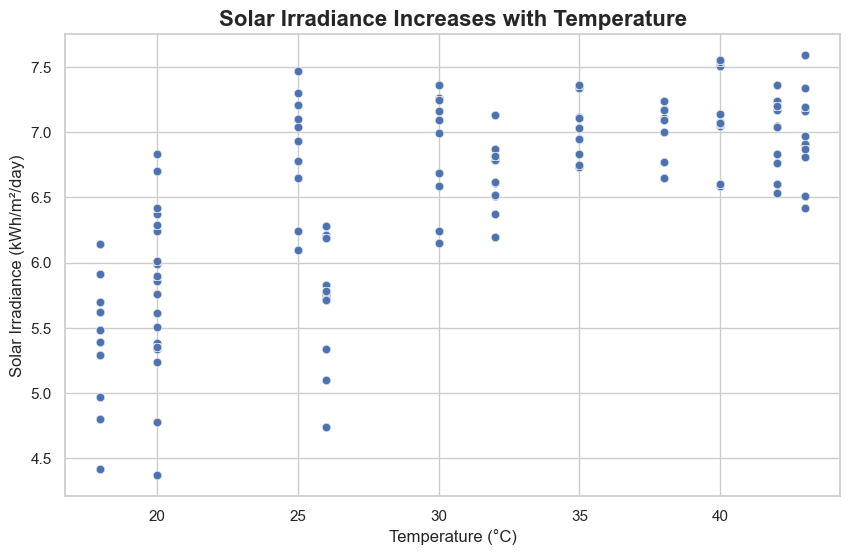

In [26]:

# Create a plot to show the relationship between Temperature and Solar Irradiance
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='temperature_celsius',
    y='solar_irradiance_kwhmday',
    alpha=0.5 # Use alpha for transparency to see dot density
)

# Add titles and labels
plt.title('Solar Irradiance Increases with Temperature', fontsize=16, weight='bold')
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Solar Irradiance (kWh/m²/day)', fontsize=12)
plt.grid(True)

# Save and show the plot
plt.savefig('output/temp_vs_irradiance_correlation.png')
plt.show()

Answering the "So what? thats negligience loss" question:

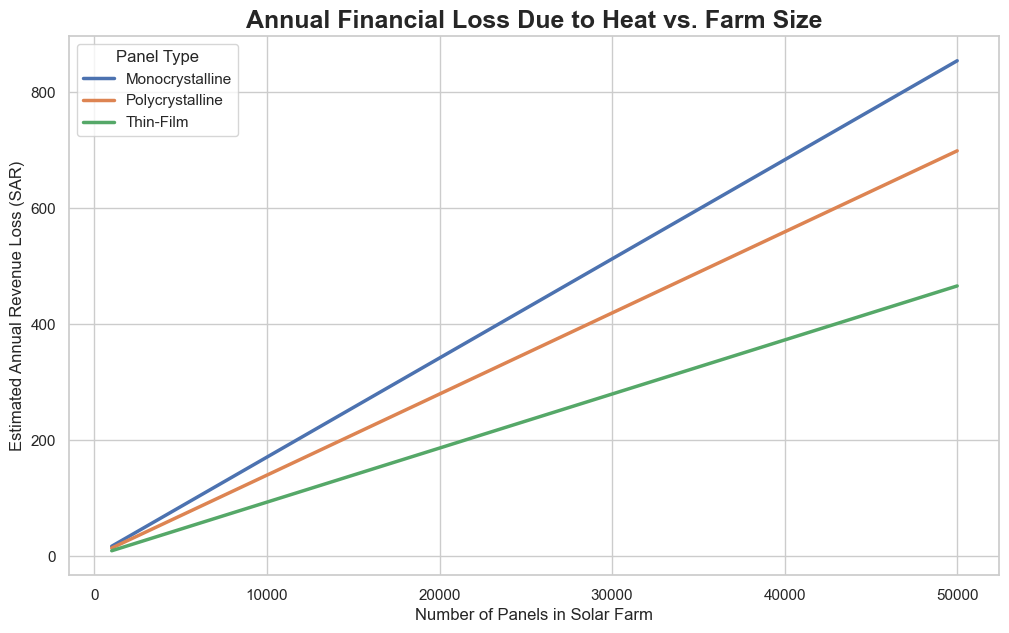

In [28]:
# 1. Define a range of solar farm sizes to model
# We'll model farms from 1,000 to 50,000 panels, in increments of 1,000.
farm_sizes = np.arange(1000, 50001, 1000)

# 2. Use the same assumptions as our calculator
baseline_temp = 25
peak_hot_temp = 48
peak_sun_hours_per_day = 5
hot_days_per_year = 150
electricity_price_sar = 0.18
temp_difference = peak_hot_temp - baseline_temp

# 3. Create a DataFrame to hold the financial calculations
financial_impact_df = pd.DataFrame({'farm_size_panels': farm_sizes})

# 4. Calculate the annual financial loss for each farm size and panel type
# Monocrystalline
mono_annual_kwh_loss_per_panel = ((temp_difference * 0.0055 * peak_sun_hours_per_day) / 1000) * hot_days_per_year
financial_impact_df['Monocrystalline_Loss_SAR'] = financial_impact_df['farm_size_panels'] * mono_annual_kwh_loss_per_panel * electricity_price_sar

# Polycrystalline
poly_annual_kwh_loss_per_panel = ((temp_difference * 0.0045 * peak_sun_hours_per_day) / 1000) * hot_days_per_year
financial_impact_df['Polycrystalline_Loss_SAR'] = financial_impact_df['farm_size_panels'] * poly_annual_kwh_loss_per_panel * electricity_price_sar

# Thin-Film
thin_film_annual_kwh_loss_per_panel = ((temp_difference * 0.0030 * peak_sun_hours_per_day) / 1000) * hot_days_per_year
financial_impact_df['Thin-Film_Loss_SAR'] = financial_impact_df['farm_size_panels'] * thin_film_annual_kwh_loss_per_panel * electricity_price_sar


# 5. Melt the DataFrame for plotting
financial_melted = financial_impact_df.melt(
    id_vars='farm_size_panels',
    value_vars=['Monocrystalline_Loss_SAR', 'Polycrystalline_Loss_SAR', 'Thin-Film_Loss_SAR'],
    var_name='panel_type',
    value_name='annual_loss_sar'
)
# Clean up the names in the 'panel_type' column for the legend
financial_melted['panel_type'] = financial_melted['panel_type'].str.replace('_Loss_SAR', '')


# 6. Create the final line plot
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=financial_melted,
    x='farm_size_panels',
    y='annual_loss_sar',
    hue='panel_type',
    linewidth=2.5
)

# 7. Add titles and labels
plt.title('Annual Financial Loss Due to Heat vs. Farm Size', fontsize=18, weight='bold')
plt.xlabel('Number of Panels in Solar Farm', fontsize=12)
plt.ylabel('Estimated Annual Revenue Loss (SAR)', fontsize=12)
plt.legend(title='Panel Type')
plt.grid(True)

# Format the y-axis to show currency
from matplotlib.ticker import FuncFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

plt.savefig('output/annual_financial_loss_vs_farm_size.png')
plt.show()